## Week 12 Lecture 2

We have studied three approaches to extending linear models. We have

- added explanatory variables through polynomial transformations involving products of features 
- encoded qualitative data through one-hot encoding
- transformed explanatory variables and response variables with logarithms

Each approach adds features to the model. 

While adding features improves the accuracy of the predictions in the sample, we need to look outside of the sample to the population. Here adding explanatory variables might worsen the accuracy of the predictions. So we need to study both a training set and a testing set. We will use the approach of cross-validation. Here we have

- training set 
- validation set 
- testing set

We will use these datasets respectively for 

- determining the parameters in a model
- figuring out the extra parameters of a model 
- assessing the accuracy of the predictions

The parameters are the missing pieces of a model that we determine by fitting the model to the data. The extra parameters distinguish different models. So cross-validation allows us to compare different model based on the data to generate accurate predictions.


In [131]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

from sklearn.linear_model import LinearRegression, Lasso

from IPython.display import Image

We will study a dataset on the fuel of efficiency of cars. Note the mpg is an acronym for miles per gallon. If the mpg is high, then the car has good fuel efficiency.

In [132]:
cars = sns.load_dataset('mpg').dropna()
cars

,mpg,cylinders,displacement,horsepower,...,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,...,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,...,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,...,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,...,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,...,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,...,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,...,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,...,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,...,18.6,82,usa,ford ranger


Note that we have 392 records with 9 features. We take `mpg` for the response variable 

- `cylinders`
- `displacement`
- `horsepower`
- `weight`
- `acceleration`
- `model_year`
- `origin`
- `name`

for the explanatory variables. Note that `origin`, `model_year`, and `name` are qualitative variables. 

### Exercise (Standard Units) 

Remember that `horsepower` and `mpg` have different scales. Here `horsepower` has two to three digits but `mpg` has one to two digits. 

In [133]:
mp_hp = cars.copy()[['mpg', 'horsepower']]
mp_hp

,mpg,horsepower
0,18.0,130.0
1,15.0,165.0
2,18.0,150.0
3,16.0,150.0
4,17.0,140.0
...,...,...
393,27.0,86.0
394,44.0,52.0
395,32.0,84.0
396,28.0,79.0


We switch to standard units to allow for a comparison between them. 

In [134]:
def transform_to_standard_unit(array):
    return (array - np.mean(array)) / np.std(array) 

Note that we subtract the mean and divide by standard deviation

In [135]:
mpg = mpg.apply(transform_to_standard_unit)

We have found two uses for standard units 

- Without standard units the scatter-plot of the variables might get skewed by different scales. Shifting and scaling the numbers allows us to visualize the linear relationship between variables 
- Gradient descent might not converge to the minimum with variables of different scales.

Moreover, standard units will be important for regularization. Check that the columns have mean 0 and standard deviation 1.

In [136]:
# TRY IT!

### Exercise (Memorizing Data) 

We should avoid adding too many features to a model. If we add too many features, then we might have overfitting. In overfitting we have small training error and large testing error. With too many features we can memorize the training data. So the in-sample will be smaller than the out-of-sample error. 

In [137]:
mpg = cars.copy()[["mpg"]]
mpg = mpg.reset_index()[:10]
mpg

,index,mpg
0,0,18.0
1,1,15.0
2,2,18.0
3,3,16.0
4,4,17.0
5,5,15.0
6,6,14.0
7,7,14.0
8,8,14.0
9,9,15.0


Suppose we want to predict `mpg`. We should study features of the car like `horsepower`. However, we can cheat with the predictions. We will add the index for a feature. Here each number is a label tell us the row in the table. Since we have qualitative data we can take a one-hot encoding. 

In [138]:
mpg_encoded = pd.get_dummies(mpg, columns=["index"])
mpg_encoded

,mpg,index_0,index_1,index_2,...,index_6,index_7,index_8,index_9
0,18.0,1,0,0,...,0,0,0,0
1,15.0,0,1,0,...,0,0,0,0
2,18.0,0,0,1,...,0,0,0,0
3,16.0,0,0,0,...,0,0,0,0
4,17.0,0,0,0,...,0,0,0,0
5,15.0,0,0,0,...,0,0,0,0
6,14.0,0,0,0,...,1,0,0,0
7,14.0,0,0,0,...,0,1,0,0
8,14.0,0,0,0,...,0,0,1,0
9,15.0,0,0,0,...,0,0,0,1


We want to take a linear model of the form 

$$\large \text{mpg} = w_0 * \text{index_0} + \ldots + w_9 * \text{index_9}$$

Each parameter $w$ is a slope. We can determine the slopes from the values in the `mpg` column. 

In [139]:
slopes = mpg_encoded["mpg"].values
slopes

array([18., 15., 18., 16., 17., 15., 14., 14., 14., 15.])

We can evaluate the predictions in-sample.

In [140]:
for row in range(len(mpg)):
    observed =  mpg_encoded.iloc[row,0]
    features =  mpg_encoded.iloc[row,1:]
    predicted = sum(features * slopes)

    print(f"Predicted: {predicted} | Observed {observed} | Error {observed - predicted}")

Predicted: 18.0 | Observed 18.0 | Error 0.0
Predicted: 15.0 | Observed 15.0 | Error 0.0
Predicted: 18.0 | Observed 18.0 | Error 0.0
Predicted: 16.0 | Observed 16.0 | Error 0.0
Predicted: 17.0 | Observed 17.0 | Error 0.0
Predicted: 15.0 | Observed 15.0 | Error 0.0
Predicted: 14.0 | Observed 14.0 | Error 0.0
Predicted: 14.0 | Observed 14.0 | Error 0.0
Predicted: 14.0 | Observed 14.0 | Error 0.0
Predicted: 15.0 | Observed 15.0 | Error 0.0


Note that we have made no errors. However we can evaluate the predictions out-of-sample. 

In [141]:
for row in range(len(mpg)):
    observed =  cars.loc[row+20, "mpg"]
    features =  mpg_encoded.iloc[row,1:]
    predicted = sum(features * slopes)

    print(f"Predicted: {predicted} | Observed {observed} | Error {observed - predicted}")

Predicted: 18.0 | Observed 25.0 | Error 7.0
Predicted: 15.0 | Observed 24.0 | Error 9.0
Predicted: 18.0 | Observed 25.0 | Error 7.0
Predicted: 16.0 | Observed 26.0 | Error 10.0
Predicted: 17.0 | Observed 21.0 | Error 4.0
Predicted: 15.0 | Observed 10.0 | Error -5.0
Predicted: 14.0 | Observed 10.0 | Error -4.0
Predicted: 14.0 | Observed 11.0 | Error -3.0
Predicted: 14.0 | Observed 9.0 | Error -5.0
Predicted: 15.0 | Observed 27.0 | Error 12.0


Here we took a different ten rows of the `cars` table. While the mpg for these cars are different, we have the same predictions. 

### Example (Cross Validation) 

Remember that we tried to predict `mpg` from `horsepower`. We found a pattern in the residuals between observed `mpg` and predicted `mpg` from `horsepower`. So we decided to try a polynomial transformation to capture a non-linear relationship betwen `mpg` and `horsepower`.  

In [142]:
def add_powers(column, n):
    data = {"power{}".format(number) : column**(number) for number in range(n+1)} 
    return pd.DataFrame(data = data)

We found that adding features improves the accuracy of predictions. However, we need to remember that we want to make predictions about a population not a sample.

In [143]:
def plotting_helper_function(data, degree, xrange):
    hp = add_powers(data, degree)

    nonlinear_model = LinearRegression(fit_intercept=False)
    nonlinear_model.fit(hp, cars["mpg"]) 

    predictions = nonlinear_model.predict(hp)
    hp_mse = np.mean((predictions - cars["mpg"].values)**2)

    to_draw = add_powers(pd.Series(data=xrange), degree)
    return nonlinear_model.predict(to_draw), hp_mse

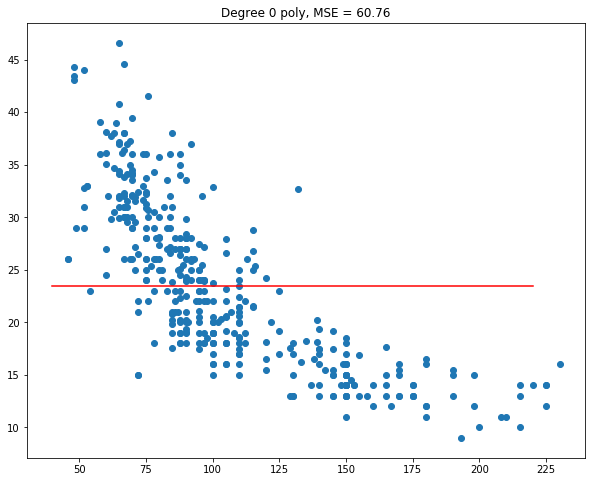

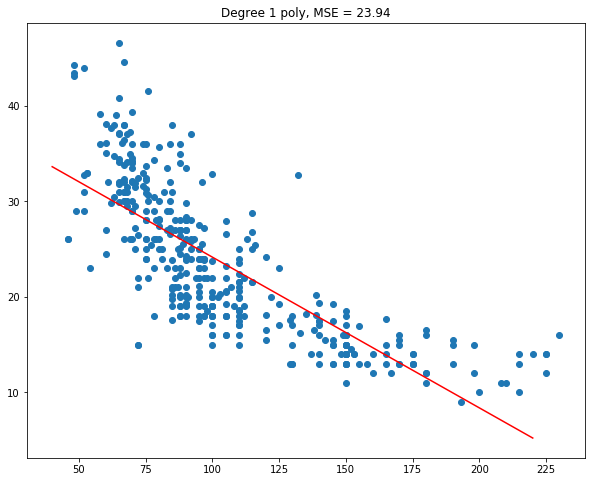

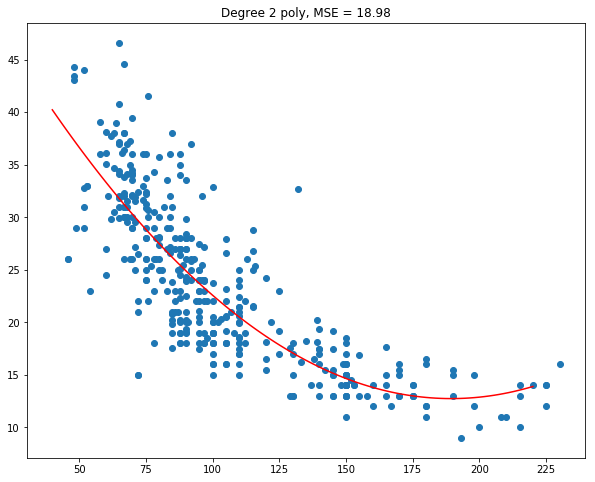

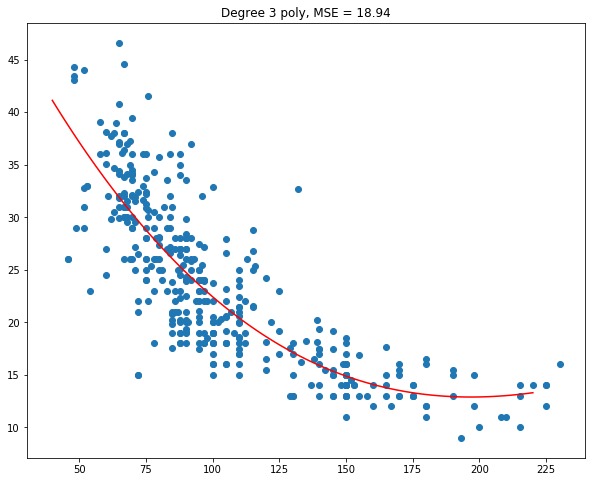

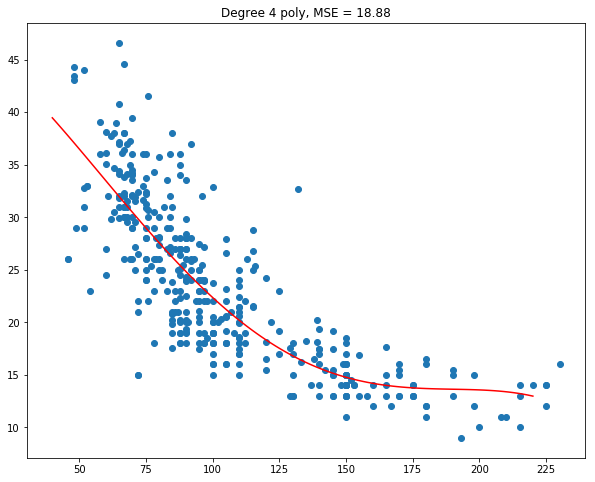

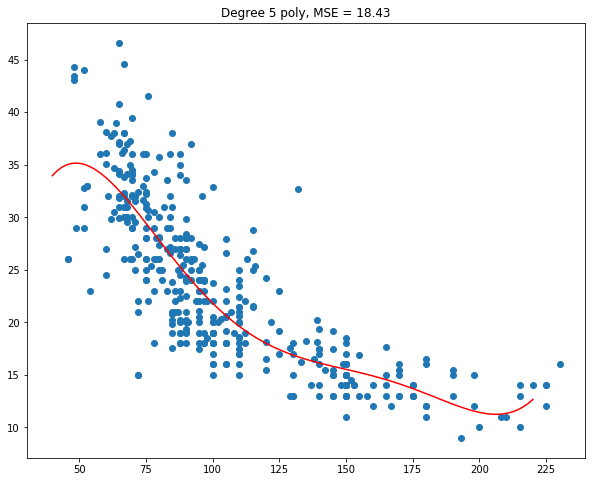

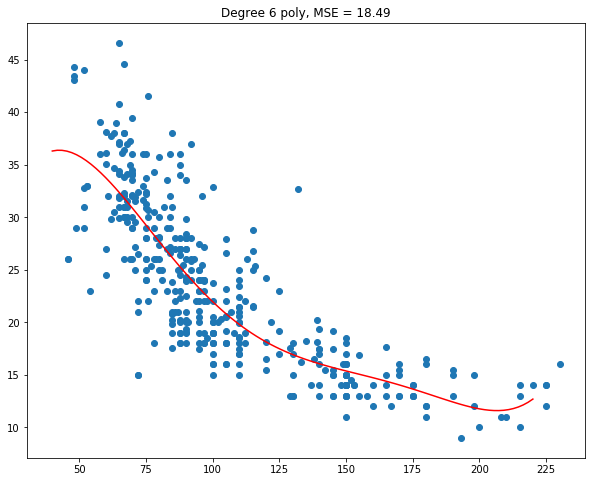

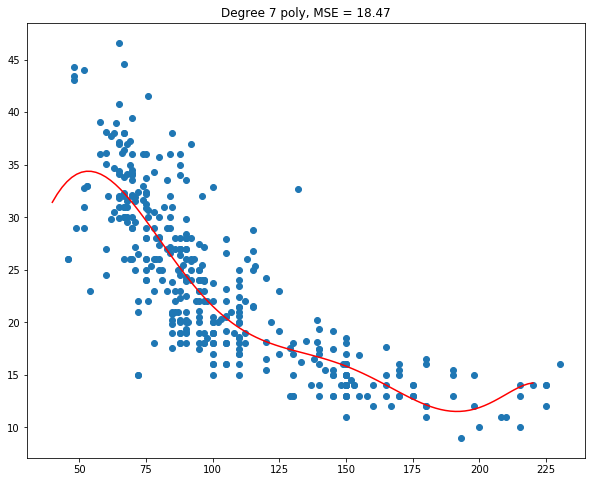

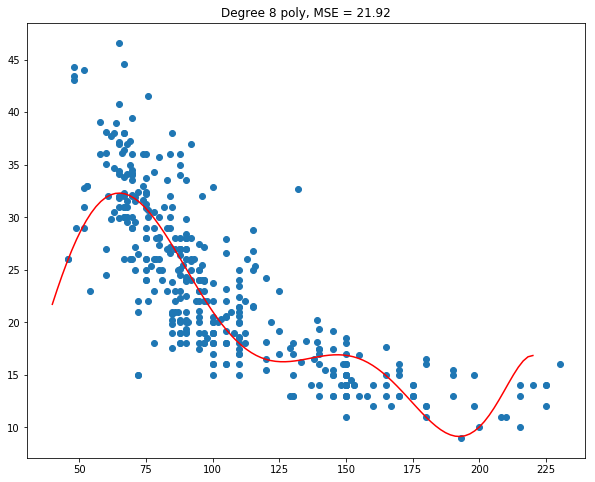

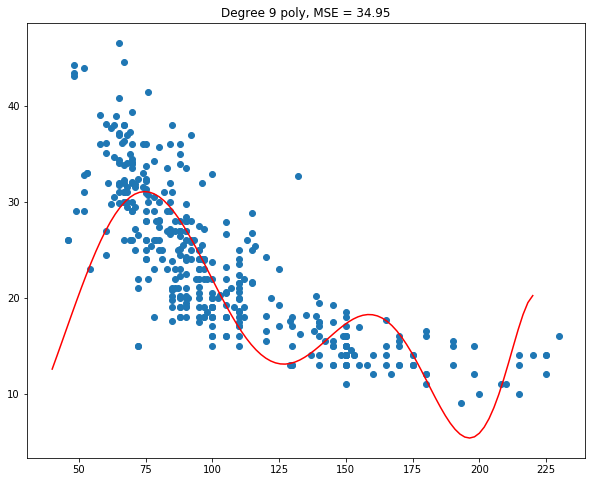

In [144]:
max_degree = 10
xrange = np.linspace(40, 220, 100)

for degree in range(0,max_degree):
    yrange, hp_mse = plotting_helper_function(cars["horsepower"], degree,xrange)
    
    plt.scatter(cars["horsepower"].values, cars["mpg"].values)
    plt.plot(xrange, yrange, c='r')
    
    plt.title(f'Degree {degree} poly, MSE = {hp_mse:.2f}')    
    plt.show();

We note that the mean square error descrease with more and more features. Instead of looking at the sample, we should try to split the sample into a training set and a testing set. 

In [145]:
# make a copy of the columns 

mpg_hp = cars.copy()[["mpg","horsepower"]]

# switch to standard units 

mpg_hp = mpg_hp.apply(transform_to_standard_unit)

We can split at random. However we want to have a reproducible split. So we set a seed to generate the same random numbers each time. 

In [146]:
number_of_rows = len(mpg_hp)
RANDOM_STATE = 47

mpg_hp_shuffled = mpg_hp.sample(n= number_of_rows, replace = False, random_state = RANDOM_STATE)

Here we have shuffled the rows of the table `cars`. By sampling with replacement, we have put the rows in a random order. So we can split into 80% training set and 20% testing set.

In [147]:
training_set = mpg_hp_shuffled[:int(0.8 * number_of_rows)]
testing_set = mpg_hp_shuffled[int(0.8 * number_of_rows):]

We should turn these steps into a function.

In [148]:
def train_test_split(data, fraction, seed = 47):
    number_of_rows = len(data)

    data_shuffled = data.sample(n= number_of_rows, replace = False, random_state = seed)
    
    training_set = data[:int(fraction * number_of_rows)]
    testing_set = data[int(fraction * number_of_rows):]
    
    return training_set, testing_set

We have to randomly shuffle the dataset before splitting into training set and test set. Otherwise, we might bias the study. For example suppose we took training set to be `usa` and testing set to be `europe` and `japan`. Remember that `usa` has worse fueld efficiency than `europe` and `japan`. So we would fit a model to data predicting low `mpg` but we would evaluate the model on data with high `mpg`. 

In [149]:
def compute_training_testing_errors_polynomial(training_set, testing_set, degree):
    # transform the training set and test set with polynomial transformation 
    
    hp_train = add_powers(training_set["horsepower"], degree)
    hp_test = add_powers(testing_set["horsepower"], degree)

    # fit a model to the training set with scikit-learn package
    
    nonlinear_model = LinearRegression(fit_intercept=False)
    nonlinear_model.fit(hp_train, training_set["mpg"]) 

    # calculate mse on training set and testing set
    
    predictions_training = nonlinear_model.predict(hp_train)
    mse_training = np.mean((predictions_training - training_set["mpg"].values)**2)

    predictions_testing = nonlinear_model.predict(hp_test)
    mse_testing = np.mean((predictions_testing - testing_set["mpg"].values)**2)
    
    return mse_training, mse_testing

We can plot the errors on training set and testing set.

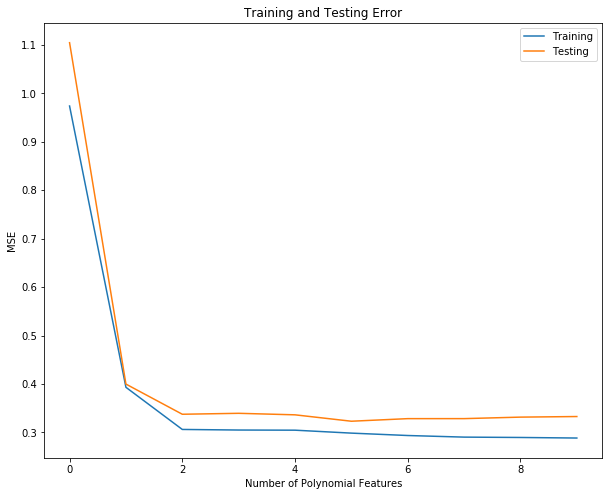

In [150]:
degrees = np.arange(10)

training_errors = []
testing_errors = []

for degree in degrees:
    mse_training, mse_testing = compute_training_testing_errors_polynomial(training_set, testing_set, degree)
    training_errors.append(mse_training)
    testing_errors.append(mse_testing)
    
plt.plot(degrees, training_errors, label = "Training")
plt.plot(degrees, testing_errors, label = "Testing")
plt.title('Training and Testing Error')
plt.xlabel('Number of Polynomial Features')
plt.ylabel('MSE')
plt.legend();

We learn that the testing error is greater than the training error. So the predictions are less accurate out-of-sample than in-sample. We should expect the training error to be less than the testing error because the predictions are based on the training error. Especially with complicated model involving many parameters, we can memorize the training set. By overfitting the training set we fail to generalize to the testing set. 

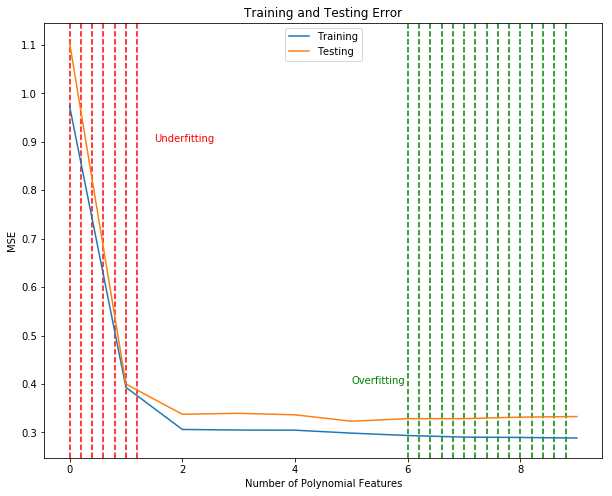

In [151]:
degrees = np.arange(10)

training_errors = []
testing_errors = []

for degree in degrees:
    mse_training, mse_testing = compute_training_testing_errors_polynomial(training_set, testing_set, degree)
    training_errors.append(mse_training)
    testing_errors.append(mse_testing)
    
for x_value in np.arange(0,1.4,0.2):
    plt.axvline(x = x_value, color = "red", linestyle = "dashed")

for x_value in np.arange(6,9,0.2):
    plt.axvline(x = x_value, color = "green", linestyle = "dashed")

plt.text(1.5,0.9,"Underfitting", fontdict={"color":"red"})    
plt.text(5,0.4,"Overfitting", fontdict={"color":"green"})    

plt.plot(degrees, training_errors, label = "Training")
plt.plot(degrees, testing_errors, label = "Testing")
plt.title('Training and Testing Error')
plt.xlabel('Number of Polynomial Features')
plt.ylabel('MSE')
plt.legend();

We can try to use cross-validation to understand the out-of-sample errors. We should split into 50% training set and 50% validation set. 

In [33]:
training_subset_1, training_subset_2 = train_test_split(training_set, 0.5)

Note that we have two folds

- training set: `training_subset_1`, validation set: `training_subset_2`
- training set: `training_subset_2`, validation set: `training_subset_1`

We can fit and assess models on each fold. So we will have two numbers to measure the average loss. 

In [39]:
degrees = np.arange(10)

validation_errors = []

for degree in degrees:
    mse_training, mse_validating_1 = compute_training_testing_errors_polynomial(training_subset_1, training_subset_2, degree)
    mse_training, mse_validating_2 = compute_training_testing_errors_polynomial(training_subset_2, training_subset_1, degree)
    
    validation_errors.append([mse_validating_1, mse_validating_2])

In [40]:
validation_errors = pd.DataFrame(data = validation_errors)
validation_errors["average"] = validation_errors.apply(np.mean, axis = 1)
validation_errors["std"] = validation_errors.apply(np.std, axis = 1)
validation_errors

,0,1,average,std
0,1.024480,0.924029,0.974255,0.041009
1,0.398050,0.402813,0.400432,0.001944
2,0.314684,0.304331,0.309507,0.004227
3,0.313807,0.303768,0.308788,0.004098
4,0.315366,0.303558,0.309462,0.004820
5,0.318331,0.295338,0.306834,0.009387
6,0.322932,0.290379,0.306656,0.013290
7,0.321380,0.284523,0.302951,0.015047
8,0.333031,0.287332,0.310181,0.018657
9,0.336912,0.299717,0.318314,0.015185


Remember that we have 2-fold cross validation. We have computed the mean square errors. The average tells us the accuracy and the standard deviation tells us the consistency.

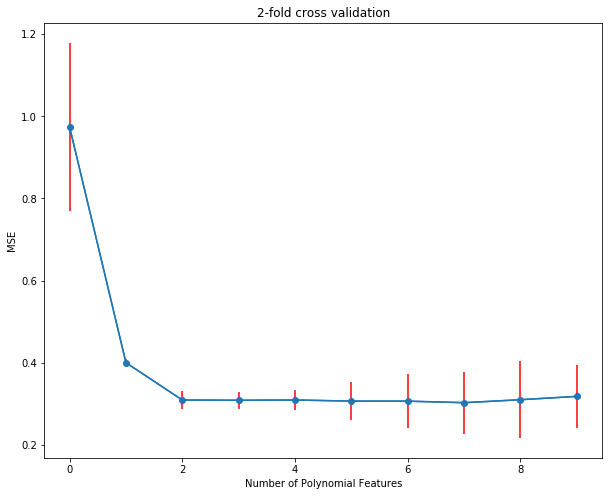

In [43]:
plt.plot(degrees, validation_errors["average"])
plt.errorbar(degrees, validation_errors["average"], yerr=5*validation_errors["std"], fmt='-o', ecolor = "r")
plt.title('2-fold cross validation')
plt.xlabel('Number of Polynomial Features')
plt.ylabel('MSE');

The error bars help to display the difference between the two folds measured by standard deviation.

### Example (Regularization) 

Suppose we try to predict `mpg` from `cylinders`, `displacement`, `horsepower`, and `acceleration`. 

In [44]:
cars_subset = cars.copy()[["mpg", "cylinders", "displacement", "horsepower", "acceleration"]]
cars_subset

,mpg,cylinders,displacement,horsepower,acceleration
0,18.0,8,307.0,130.0,12.0
1,15.0,8,350.0,165.0,11.5
2,18.0,8,318.0,150.0,11.0
3,16.0,8,304.0,150.0,12.0
4,17.0,8,302.0,140.0,10.5
...,...,...,...,...,...
393,27.0,4,140.0,86.0,15.6
394,44.0,4,97.0,52.0,24.6
395,32.0,4,135.0,84.0,11.6
396,28.0,4,120.0,79.0,18.6


Before we make any predictions we should switch to standard units and split between training and testing.

In [45]:
# change to standard units

cars_subset = cars_subset.apply(transform_to_standard_unit)

# split into training and testing

training_set, testing_set = train_test_split(cars_subset, 0.8)

Which features help use to predict `mpg`? We can remove a feature to assess the impact on predictions.

In [46]:
def compute_training_testing_errors_subset(training_set, testing_set, subset):
    # fit a model to the training set with scikit-learn package
    
    nonlinear_model = LinearRegression(fit_intercept=False)
    nonlinear_model.fit(training_set[subset], training_set["mpg"]) 

    # calculate mse on training set and testing set
    
    predictions_training = nonlinear_model.predict(training_set[subset])
    mse_training = np.mean((predictions_training - training_set["mpg"].values)**2)

    predictions_testing = nonlinear_model.predict(testing_set[subset])
    mse_testing = np.mean((predictions_testing - testing_set["mpg"].values)**2)
    
    return mse_training, mse_testing

We will drop one feature from the table, fit a linear model and calculate the accuracy of the prediction with the mean square error.

In [97]:
subset_errors = dict()

for column in ['cylinders', 'displacement', 'horsepower', 'acceleration']:
    subset = cars_subset.columns.drop(['mpg', column])
    subset_errors[column] = compute_training_testing_errors_subset(training_set, testing_set, subset)

subset_errors = pd.DataFrame(data = subset_errors, index = ["Training", "Testing"])
subset_errors

,cylinders,displacement,horsepower,acceleration
Training,0.226346,0.230672,0.245172,0.239790
Testing,0.774126,0.777707,0.815844,0.754157


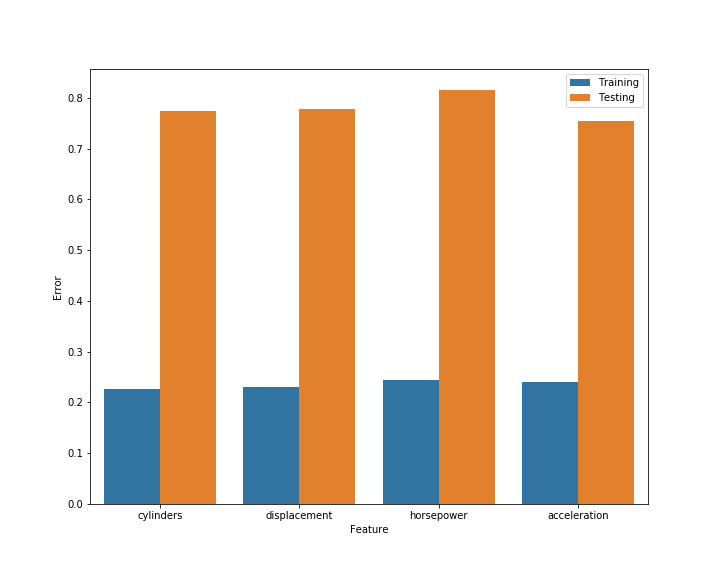

In [76]:
Image("barchart.png")

Note that dropping `acceleration` gives a model with lowest error on the testing set. So we can reduce from four features to three features by dropping `acceleration`. If we continued to compare features, then we could get down to just one explanatory variable. Note that we had to fit many models to the data for the comparison. We want another approach to determining important features. 

Remember that the mean square error for a linar model is 

$$L(a,b; x_1,\ldots,x_n,y_1,\ldots,y_n) = \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2$$ 

We want to minimize the average loss. Take $\lambda$ to be positive number like 0.1. We can add another term to the average loss.  

$$L(a,b; \lambda, x_1,\ldots,x_n,y_1,\ldots,y_n) = \lambda \left( |a| + |b| \right) + \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2   $$ 

Again we can try to minimize the function. Now we want to make the differences between observations and predictions small along with the slope and intercept. The term 

$$ \lambda \left( |a| + |b| \right) $$

is small for $a$ and $b$ close to zero.

In [127]:
lasso_models = dict()

for extra_parameter in np.logspace(-10,10,10):
    lasso_model = Lasso(alpha = extra_parameter, fit_intercept=False)
    lasso_model.fit(training_set.drop(columns = "mpg"), training_set["mpg"])
    
    lasso_models[extra_parameter] = lasso_model

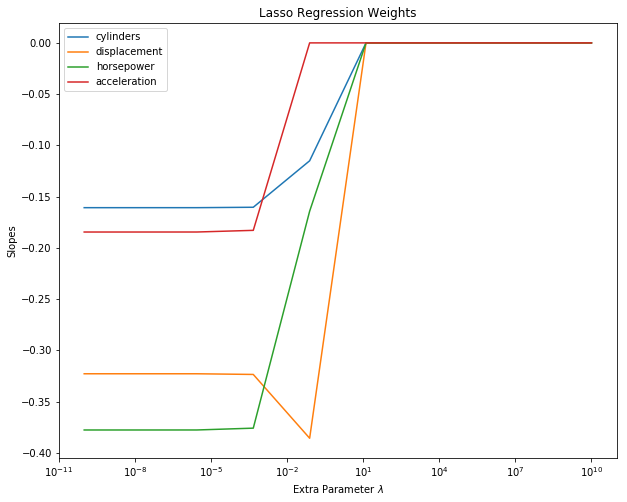

In [128]:
labels =['cylinders', 'displacement', 'horsepower', 'acceleration']

coefs = []
for alpha, model in lasso_models.items():
    coefs.append(model.coef_)

coefs = zip(*coefs)

fig, ax = plt.subplots(ncols=1, nrows=1)

for coef, label in zip(coefs, labels):
    plt.semilogx(list(lasso_models.keys()), coef, label = label)


plt.xlabel('Extra Parameter $\lambda$')
plt.ylabel('Slopes')
plt.title('Lasso Regression Weights')
plt.legend();

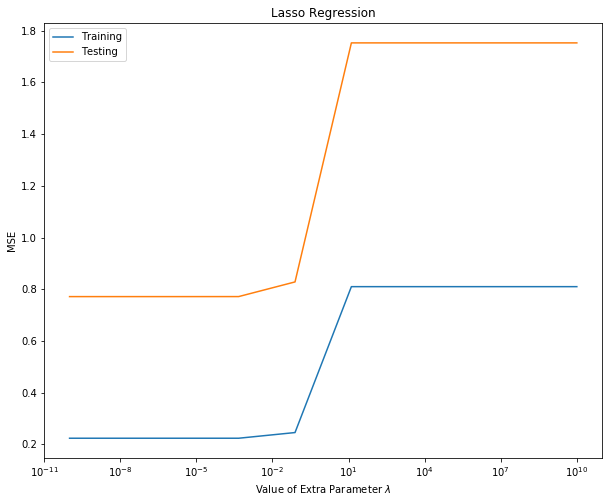

In [129]:
training_errors = []
testing_errors = []
for extra_parameter, model in lasso_models.items():
    mse_testing = np.mean( (model.predict(testing_set.drop(columns = "mpg")) - testing_set["mpg"] )**2)
    testing_errors.append(mse_testing)
    
    mse_training = np.mean( (model.predict(training_set.drop(columns = "mpg")) - training_set["mpg"] )**2)
    training_errors.append(mse_training)
    
plt.semilogx(list(lasso_models.keys()), training_errors, label="Training")
plt.semilogx(list(lasso_models.keys()), testing_errors, label="Testing")
plt.title('Lasso Regression')
plt.xlabel('Value of Extra Parameter $\lambda$')
plt.ylabel('MSE')
plt.legend();